In [0]:
import os
import scipy.io as scio
import numpy as np
import jax
from jax import jit
from jax import lax
import matplotlib.pyplot as plt

In [0]:
params_1a = {
    "Cm": 1,  # membrane capacitance (microF / cm^2)
    "V_c": 0.13,
    "V_v": 0.04,
    "tau_d": 0.395,  # excitability
    "tau_v1_minus": 9,  # Fast_inward_current_v_gate (ms)
    "tau_v2_minus": 8,  # Fast_inward_current_v_gate (ms)
    "tau_v_plus": 3.33,  # Fast_inward_current_v_gate (ms)
    "tau_0": 9,  # Slow_outward_current (ms)
    "tau_r": 33.33,  # Slow_outward_current (ms)
    "tau_si": 29,  # Slow_inward_current (ms)
    "V_csi": 0.50,  # Slow_inward_current (dimensionless)
    "k": 15,  # Slow_inward_current (dimensionless)
    "tau_w_minus": 60,  # Slow_inward_current_w_gate (ms)
    "tau_w_plus": 250,  # Slow_inward_current_w_gate (ms)
    "D": 0.05,  # X diffusivity (cm^2/ms)
}
params_test = {
    "Cm": 1,  # membrane capacitance (microF / cm^2)
    "V_c": 0.16,
    "V_v": 0.16,
    "tau_d": 0.125, # excitability
    "tau_v1_minus": 82.5,  # Fast_inward_current_v_gate (ms)
    "tau_v2_minus": 60,  # Fast_inward_current_v_gate (ms)
    "tau_v_plus": 5.75,  # Fast_inward_current_v_gate (ms)
    "tau_0": 32.5,  # Slow_outward_current (ms)
    "tau_r": 70,  # Slow_outward_current (ms)
    "tau_si": 114,  # Slow_inward_current (ms)
    "V_csi": 0.85,  # Slow_inward_current (dimensionless)
    "k": 10,  # Slow_inward_current (dimensionless)
    "tau_w_minus": 400,  # Slow_inward_current_w_gate (ms)
    "tau_w_plus": 300,  # Slow_inward_current_w_gate (ms)
    "D": 0.05,  # diffusivity
}

In [0]:
# @jit
def step(state, t, params, D, stimuli, dt, h):
    v, w, u = state
    
    # apply stimulus
    u = stimulate(t, u, stimuli)

    # apply boundary conditions
    v = neumann_np(v)
    w = neumann_np(w)
    u = neumann_np(u)

    # gate variables
    p = np.greater_equal(u, params["V_c"])
    q = np.greater_equal(u, params["V_v"])
    tau_v_minus = (1 - q) * params["tau_v1_minus"] + q * params["tau_v2_minus"]
    
    d_v = ((1 - p) * (1 - v) / tau_v_minus) - ((p * v) / params["tau_v_plus"])
    d_w = ((1 - p) * (1 - w) / params["tau_w_minus"]) - ((p * w) / params["tau_w_plus"])
      
    # currents
    J_fi = - v * p * (u - params["V_c"]) * (1 - u) / params["tau_d"]
    J_so = (u * (1 - p) / params["tau_0"]) + (p / params["tau_r"])
    J_si = - (w * (1 + np.tanh(params["k"] * (u - params["V_csi"])))) / (2 * params["tau_si"])
    I_ion = -(J_fi + J_so + J_si) / params["Cm"]

    # voltage
    u_x, u_y = np.gradient(u, h, edge_order=2)
    u_xx = np.gradient(u_x, h, edge_order=2, axis=0)
    u_yy = np.gradient(u_y, h, edge_order=2, axis=1)
    D_x, D_y = np.gradient(D, h, edge_order=2)
    d_u = D * (u_xx + u_yy) + ((D_x * u_x) + (D_y * u_y)) + I_ion
    return euler((v, w, u), (d_v, d_w, d_u), dt)

# @jit
def euler(state, grad, dt):
    v, w, u = state
    d_v, d_w, d_u = grad

    # explicit euler update
    v += d_v * dt
    w += d_w * dt
    u += d_u * dt
    return (v, w, u)

# @jit
def neumann(X):
    X = jax.ops.index_update(X, [0], X[1])
    X = jax.ops.index_update(X, [-1], X[-2])
    X = jax.ops.index_update(X, [..., 0], X[..., 1])
    X = jax.ops.index_update(X, [..., -1], X[..., -2])
    return X

def neumann_np(X):
    X[0] = X[1]
    X[-1] = X[-2]
    X[..., 0] = X[..., 1]
    X[..., -1] = X[..., -2]
    return X

# @jit
def stimulate(t, X, stimuli):
    for stimulus in stimuli:
        active = np.where(t < stimulus["start"], 1, 0)
        active |= ((t - stimulus["start"]) % stimulus["period"]) < stimulus["duration"]
        X = np.where(stimulus["field"] * (active), stimulus["field"], X)
    return X

# @jit
def forward_jit(length, params, D, stimuli, dt, h):
    shape = (128, 128)
    v = np.zeros(shape)
    w = np.zeros(shape)
    u = np.zeros(shape)
    t = 0

    init = (v, w, u)
    return lax.fori_loop(t, length, lambda i, s: step(s, i * dt, params, D, stimuli, dt), init)

def forward(length, params, D, stimuli, dt, h, log_at=10):
    # init
    shape = (128, 128)
    v = np.ones(shape)*0.99
    w = np.ones(shape)*0.99
    u = np.zeros(shape)
    state = (v, w, u)
    
    # iterate
    for i in np.arange(0, length, dt):
        # step
        state = step(state, i, params, D, stimuli, dt, h)
        
        #show
        print("t: %s ms\t\t\t" % i , end="\r")
        if not (i % log_at):
            im = plt.imshow(state[2], vmin=-.8, vmax=.8, cmap="RdBu")
            plt.colorbar(im)
            plt.show()
    return state

In [0]:
# resolution
shape = (128, 128)
dt = 0.01

# parameters
params = params_test
D = np.ones(shape) * params["D"] 

# stimuli
field = np.zeros(shape)
field[20:40, 20:40] = .8
# field = jax.ops.index_update(field, slice(0, 20), .95)
stimulus = {
    "field": field,
    "start": 0,
    "duration": dt,
    "period": float("inf")
}

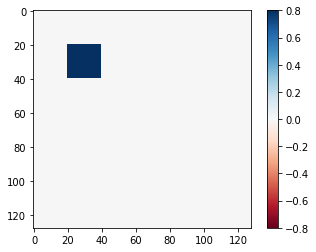

In [0]:
%%time
state = forward(2000, params_test, D, [stimulus], dt, 0.3, log_at=200000)

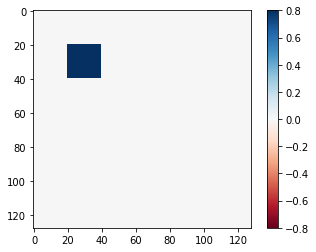

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
im = ax[0].imshow(state[0], vmin=0, vmax=1, cmap="RdBu")
plt.colorbar(im, ax=ax[0])
ax[0].set_title("v")
im = ax[1].imshow(state[1], vmin=0, vmax=1, cmap="RdBu")
plt.colorbar(im, ax=ax[1])
ax[1].set_title("w")
im = ax[2].imshow(state[2], vmin=0, vmax=1, cmap="RdBu")
plt.colorbar(im, ax=ax[2])
ax[2].set_title("u")

In [0]:
matlab_results = []
for file in os.listdir("/home/epignatelli/Downloads/FK_Matlab/data/"):
    matlab_results.append(scio.loadmat("/home/epignatelli/Downloads/FK_Matlab/data/%s" % file)["u"])
matlab_results = np.array(matlab_results)

In [0]:
scio.loadmat("/home/epignatelli/Downloads/FK_Matlab/data/100.mat")["u"]

array([[0.3150995 , 0.3150995 , 0.31868893, ..., 0.84621607, 0.84807788,
        0.84807788],
       [0.3150995 , 0.3150995 , 0.31868893, ..., 0.84621607, 0.84807788,
        0.84807788],
       [0.31868893, 0.31868893, 0.32252753, ..., 0.8459761 , 0.84783704,
        0.84783704],
       ...,
       [0.84621607, 0.84621607, 0.8459761 , ..., 0.9752197 , 0.97595808,
        0.97595808],
       [0.84807788, 0.84807788, 0.84783704, ..., 0.97595808, 0.97669288,
        0.97669288],
       [0.84807788, 0.84807788, 0.84783704, ..., 0.97595808, 0.97669288,
        0.97669288]])